In [1]:
from collections import Counter
from copy import copy
import io
from pathlib import Path
import pickle
from typing import Callable, Dict

import fasttext.util
from imblearn.base import BaseSampler
from imblearn import over_sampling
import joblib
from matplotlib import pyplot as plt
import numpy as np
import lightgbm as lgb
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
import spacy
from tqdm.notebook import tqdm

from jjuoda_dl4.utils import BASE_DATA_DIR, BASE_MODEL_DIR

In [2]:
df_merged = pd.read_csv(BASE_DATA_DIR / "final" / "merged.csv")
df_merged.head()

,title,text,subject,date,is_fake,num_words_text,num_words_title
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",False,746,10
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",False,621,9
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",False,454,10
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",False,372,9
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",False,849,11


In [3]:
# drop rows where both text and title were cleaned to empty string
df_merged = df_merged[~(df_merged.title.isna() & df_merged.text.isna())]

# fill in nan values with empty string
df_merged.title.fillna("", inplace=True)
df_merged.text.fillna("", inplace=True)

### Baseline heuristic

#### Words in all caps

In [4]:
def count_all_caps(texts: pd.Series):
    return texts.str.count(r"\b[A-Z]{2,}\b")


def get_caps_table(texts: pd.Series, is_fake: pd.Series):
    num_words = texts.str.split().str.len().values
    num_caps = count_all_caps(texts).values

    is_fake = is_fake[num_words > 0]
    num_caps = num_caps[num_words > 0]
    num_words = num_words[num_words > 0]

    cap_frequency = num_caps / num_words

    mean_caps_true = cap_frequency[~is_fake].mean()
    mean_caps_fake = cap_frequency[is_fake].mean()

    return mean_caps_true, mean_caps_fake


mean_caps_title_true, mean_caps_title_fake = get_caps_table(
    df_merged.title, df_merged.is_fake
)
mean_caps_text_true, mean_caps_text_fake = get_caps_table(
    df_merged.text, df_merged.is_fake
)


def _get_caps_odds(texts, mean_true, mean_fake):
    num_caps = count_all_caps(texts).values
    num_words = texts.str.split().str.len().values
    cap_frequency = num_caps / num_words
    text_odds = np.ones((len(cap_frequency), 2))
    text_odds[cap_frequency < mean_true] = np.array([[4, 1]])
    text_odds[cap_frequency > mean_fake] = np.array([[1, 4]])

    mask = np.logical_and(cap_frequency >= mean_true, cap_frequency <= mean_fake)
    dist_true = cap_frequency - mean_true
    dist_fake = cap_frequency - mean_fake

    text_odds[mask & (dist_true < dist_fake)] = np.array([[2, 3]])
    text_odds[mask & (dist_true > dist_fake)] = np.array([[3, 2]])
    return text_odds


def get_caps_odds(df: pd.DataFrame):
    text_odds = _get_caps_odds(df.text, mean_caps_title_true, mean_caps_title_fake) / 2
    text_odds[text_odds < 1] = 1  # reduce difference between fake and true
    title_odds = _get_caps_odds(df.title, mean_caps_title_true, mean_caps_title_fake)

    return text_odds * title_odds

In [5]:
sample = df_merged.sample(10)
sample[["true_odds", "fake_odds"]] = get_caps_odds(sample)
with pd.option_context("display.max_colwidth", 120, "expand_frame_repr", False):
    print(sample[["title", "is_fake", "true_odds", "fake_odds"]])

                                                                                                                         title  is_fake  true_odds  fake_odds
40981  TALENTLESS Gigi Hadid Makes Ridiculous “Apology” For Mocking Immigrant Melania’s Accent: “I believe Melania understa...     True        6.0        2.0
29830                                                Even Trump’s Own Ex-Organizer Accuses Him Of Discriminating Against Women     True        8.0        1.0
23378                                             WATCH: Conservationist Jane Goodall BLASTS Trump’s Attack On Climate Science     True        6.0        2.0
2115                                                 Decision on whether Trump adviser Bannon keeps his job is imminent: Axios    False        8.0        1.0
28385                                                                    Meet Zari, The First Feminist Muppet From Afghanistan     True        8.0        1.0
27653                                             Tr

In [6]:
eval = df_merged.copy()
eval[["true_odds", "fake_odds"]] = get_caps_odds(eval)
((eval.true_odds < eval.fake_odds) == eval.is_fake).mean()

/tmp/ipykernel_2576079/335387911.py:32: RuntimeWarning: invalid value encountered in true_divide
  cap_frequency = num_caps / num_words


0.6817705896767582

In [7]:
get_caps_odds(df_merged.loc[[30540]])

array([[1.5, 4. ]])

#### Keyword search

In [8]:
# nlp = spacy.load("en_core_web_sm")

In [9]:
def extract_keywords(texts: pd.Series, mask):
    keywords = Counter()
    for doc in nlp.pipe(df_merged.text[mask].str.lower(), batch_size=100):
        keywords.update(str(s).lower() for s in doc.ents)

    return (
        pd.DataFrame(keywords.items(), columns=["keyword", "count"])
        .sort_values("count", ascending=False)
        .reset_index(drop=True)
    )

In [10]:
# fake_keywords = extract_keywords(df_merged.text, df_merged.is_fake)
# fake_keywords.head()

In [11]:
# fake_keywords_title = extract_keywords(df_merged.title, df_merged.is_fake)
# fake_keywords_title.head()

In [12]:
# true_keywords = extract_keywords(df_merged.text, ~df_merged.is_fake)
# true_keywords.head()

In [13]:
# true_keywords_title = extract_keywords(df_merged.title, ~df_merged.is_fake)
# true_keywords_title.head()

In [14]:
# set(fake_keywords.head(100).keyword) - set(true_keywords.head(200).keyword)

In [15]:
# set(fake_keywords_title.head(100).keyword) - set(true_keywords_title.head(200).keyword)

Hm, maybe:  
- cia makes sense to appear more in conspiracy theories/fake news.
- islam knowing that most of fake news come from American right
- Hillary Clinton is likely mentioned by both a lot, since the period is 2015-2017, but Bill Clinton is a surprise

In [16]:
# set(true_keywords.head(100).keyword) - set(fake_keywords.head(200).keyword)

In [17]:
# set(true_keywords.head(100).keyword) - set(fake_keywords.head(200).keyword)

Much more international news. In this dataset fake news are about US politics.

In [18]:
true_keywords_set = {
    "beijing",
    "britain",
    "eu",
    "japan",
    "myanmar",
    "north korean",
    "puerto rico",
    "south korea",
    "taiwan",
    "the european union",
    "the united nations",
    "turkish",
    "u.n.",
}
fake_keywords_set = set(
    ["conspiracy", "cia", "islam", "bill clinton", "video", "lol", "wow"]
)


def contains_keywords(text: str, keywords: set):
    return sum(s.lower() in keywords for s in text.split())


def _get_keyword_odds(texts: pd.Series):
    true_keywords_count = texts.apply(
        lambda x: contains_keywords(x, true_keywords_set)
    ).values.reshape(-1, 1)
    fake_keywords_count = texts.apply(
        lambda x: contains_keywords(x, fake_keywords_set)
    ).values.reshape(-1, 1)
    return np.concatenate([true_keywords_count + 1, fake_keywords_count + 1], axis=1)


def get_keyword_odds(df: pd.DataFrame):
    text_odds = _get_keyword_odds(df.text)
    title_odds = _get_keyword_odds(df.title)
    return text_odds * title_odds

In [19]:
sample = df_merged.sample(10)
sample[["true_odds", "fake_odds"]] = get_keyword_odds(sample)
with pd.option_context("display.max_colwidth", 120, "expand_frame_repr", False):
    print(sample[["title", "is_fake", "true_odds", "fake_odds"]])

                                                                                                             title  is_fake  true_odds  fake_odds
10325                                           Senate Republican leader: Obama politicizing Supreme Court process    False          1          1
36543                                                WOW! Look Who Just Knocked Trump Out Of The  Spot In GOP Poll     True          1          1
24465                    Mexican President Tells Trump One More Time That Mexico Isn’t Paying For His Stupid Wall      True          1          1
33935                                                HA! THEY’RE NOT FORGETTING About Hillary At The World Series!     True          1          1
6001                                 Trump says plans lots of bilateral trade deals with quick termination clauses    False          1          1
19369                                              South African minister calls for ANC to discipline Zuma: report    False 

#### All odds together

In [20]:
def get_odds(df: pd.DataFrame):
    odd_funcs = [get_caps_odds, get_keyword_odds]
    odds = np.ones((len(df), 2))
    for func in odd_funcs:
        odds *= func(df)
    return odds


def predict_proba(df: pd.DataFrame):
    odds = get_odds(df)
    return odds / odds.sum(axis=1, keepdims=True)


def predict(df: pd.DataFrame):
    return predict_proba(df).argmax(axis=1)

In [21]:
eval = df_merged.copy()
eval[["true_odds", "fake_odds"]] = get_odds(eval)
((eval.true_odds < eval.fake_odds) == eval.is_fake).mean()

/tmp/ipykernel_2576079/335387911.py:32: RuntimeWarning: invalid value encountered in true_divide
  cap_frequency = num_caps / num_words


0.6911270021608857

Ok, keyword extraction was work and didn't help much.

### Classical models

In [22]:
pretrained_fasttext = fasttext.load_model(str(BASE_MODEL_DIR / "cc.en.300.bin"))

In [23]:
encodings = np.array(
    [pretrained_fasttext.get_sentence_vector(s.lower()) for s in df_merged.text]
)

In [24]:
logistic_regression = LogisticRegression(solver="lbfgs", max_iter=1000)
logistic_regression.fit(encodings, df_merged.is_fake)

LogisticRegression(max_iter=1000)

In [25]:
(logistic_regression.predict(encodings) == df_merged.is_fake).mean()

0.9374902537369957

Dataset is horrendous. Distinguishing real news from fake news could be pretty hard, but in this case real news only comes from Reuters and fake news come from random sources, mostly twitter. They are very different and even after cleaning up dataset a bit, simple logistic regression achieves 94.7% accuracy without any feature engineering.

#### Evaluation against nela-gt-2018

In [26]:
nela_gt_2018_articles_df = pd.read_csv(
    BASE_DATA_DIR / "interim" / "nela-gt-2018-articles.csv", index_col=0
)
nela_gt_2018_articles_df.head()

,path,title,date,source,source_score
0,raw/NELA-GT-2018/articles/2018-09-08/Business ...,Dozens of manufacturing companies testified ab...,2018-09-08,Business Insider,2.0
1,raw/NELA-GT-2018/articles/2018-09-08/RT/RT--20...,Pentagon routinely briefs Trump on military op...,2018-09-08,RT,0.0
2,raw/NELA-GT-2018/articles/2018-09-08/RT/RT--20...,US Air Force determining facts appropriate pro...,2018-09-08,RT,0.0
3,raw/NELA-GT-2018/articles/2018-09-08/RT/RT--20...,Pentagon designing Glide Breaker interceptor t...,2018-09-08,RT,0.0
4,raw/NELA-GT-2018/articles/2018-09-08/RT/RT--20...,Developing nation US cant afford to subsidize ...,2018-09-08,RT,0.0


In [27]:
nela_gt_2018_scores_df = pd.read_csv(
    BASE_DATA_DIR / "interim" / "nela-gt-2018-scores.csv", index_col=0
)

In [28]:
nela_gt_2018_articles_df["is_fake"] = np.nan

In [29]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i : i + n]


def batched_preprocessing(
    articles_df: pd.DataFrame,
    ft_encoder,
    batch_size: int = 128,
    root_dir: Path = BASE_DATA_DIR,
):
    articles_df = articles_df.dropna(subset=["title"])
    for batch_indices in tqdm(chunks(articles_df.index, batch_size)):
        text_encodings = []
        for article_path in articles_df.loc[batch_indices].path:
            with open(root_dir / article_path, "r") as f:
                text = f.read().replace("\n", " ")
            text_encodings.append(ft_encoder.get_sentence_vector(text.lower()))
        text_encodings = np.array(text_encodings)
        title_encodings = np.array(
            [
                ft_encoder.get_sentence_vector(s.lower())
                for s in articles_df.loc[batch_indices].title
            ]
        )
        encodings = np.concatenate([text_encodings, title_encodings], axis=1)
        yield encodings, articles_df.loc[batch_indices].is_fake


def batched_predictions(articles: pd.DataFrame, ft_encoder, model, batch_size=128):
    for text_encodings, _ in batched_preprocessing(articles, ft_encoder, batch_size):
        preds = model.predict_proba(text_encodings)
        yield preds


def batched_training(articles_df: pd.DataFrame, ft_encoder, model, batch_size=128):
    for text_encodings, is_fake in batched_preprocessing(
        articles_df, ft_encoder, batch_size
    ):
        model.partial_fit(text_encodings, is_fake, classes=[0, 1])

In [30]:
# predicted_probas = np.concatenate(list(batched_predictions(nela_gt_2018_articles_df, pretrained_fasttext, logistic_regression)))

In [31]:
# ax = sns.boxplot(x=nela_gt_2018_articles_df.source_score, y=predicted_probas[:, 0])

# ax.set_ylabel("Probability of being fake")

# plt.savefig(BASE_DATA_DIR / "processed" / "nela-gt-2018-articles-probability-of-being-fake.png")

I am not sure I assigned scores to sources correctly, however, I'm pretty sure that as we increase source score, proportion of reliable news increases. As I feared, model trained on the original dataset generalizes poorly. Let's train our model on articles I'm most confident about.

In [32]:
def _make_dataframe(articles_df, root_dir=BASE_DATA_DIR):
    articles_df = articles_df.copy()
    for index, article in tqdm(articles_df.iterrows(), total=articles_df.shape[0]):
        with open(root_dir / article.path, "r") as f:
            text = f.read().replace("\n", " ")
        articles_df.loc[index, "text"] = text
    return articles_df


def split_dataframe(
    articles_df,
    scores_df,
    source_thresh_reliable=2.5,
    source_thresh_unreliable=-2,
    n_val_sources=1,
):
    reliable_sources = scores_df[scores_df.score >= source_thresh_reliable]
    unreliable_sources = scores_df[scores_df.score <= source_thresh_unreliable]

    val_unreliable_sources = unreliable_sources.iloc[:n_val_sources]
    train_unreliable_sources = unreliable_sources.iloc[n_val_sources:]

    # I have way more reliable news sources than unreliable news sources
    # so I'll ensure that every split has more reliable sources than unreliable sources
    val_reliable_sources = reliable_sources.iloc[: n_val_sources + 1]
    train_reliable_sources = reliable_sources.iloc[n_val_sources + 1 :]

    train_sources = pd.concat([train_reliable_sources, train_unreliable_sources])
    val_sources = pd.concat([val_reliable_sources, val_unreliable_sources])

    articles_df["split"] = "pred"
    articles_df.loc[articles_df.source.isin(train_sources.index), "split"] = "train"
    articles_df.loc[articles_df.source.isin(val_sources.index), "split"] = "val"

    print(
        "We have:\n"
        f"{len(train_reliable_sources)} reliable sources in train\n"
        f"{len(train_unreliable_sources)} unreliable sources in train\n"
        f"For a total of {sum(articles_df.split == 'train')} articles in train\n"
        f"{len(val_reliable_sources)} reliable sources in val\n"
        f"{len(val_unreliable_sources)} unreliable sources in val\n"
        f"For a total of {sum(articles_df.split == 'val')} articles in val\n"
    )

    return articles_df


def _balance_by_dropping(dataframe):
    real = dataframe[~dataframe.is_fake]
    fake = dataframe[dataframe.is_fake]
    # I have way more articles of real news
    drop_real = max(0, real.shape[0] - fake.shape[0])
    real = real.sample(n=real.shape[0] - drop_real, random_state=42)
    print(f"Dropped {drop_real} real articles")
    return pd.concat([fake, real]).sort_index()


def make_train_dataframes(
    articles_df,
    scores_df,
    source_thresh_reliable=2,
    source_thresh_unreliable=-2,
    n_val_sources=2,
    balance=False,
):
    articles_df["is_fake"] = articles_df.source_score < 0
    articles_df = split_dataframe(
        articles_df,
        scores_df,
        source_thresh_reliable,
        source_thresh_unreliable,
        n_val_sources,
    )

    print("Processing train articles")
    train_split = articles_df[articles_df.split == "train"]
    if balance:
        train_split = _balance_by_dropping(train_split)
    print("Reading train articles")
    train_articles_df = _make_dataframe(train_split)
    train_articles_df = train_articles_df.sample(frac=1, random_state=42)  # shuffle

    print("Processing val articles")
    val_split = articles_df[articles_df.split == "val"]
    if balance:
        val_split = _balance_by_dropping(val_split)
    print("Reading val articles")
    val_articles_df = _make_dataframe(val_split)

    return train_articles_df, val_articles_df


train_articles_df, val_articles_df = make_train_dataframes(
    nela_gt_2018_articles_df, nela_gt_2018_scores_df
)

We have:
33 reliable sources in train
13 unreliable sources in train
For a total of 174847 articles in train
3 reliable sources in val
2 unreliable sources in val
For a total of 25606 articles in val

Processing train articles
Reading train articles


  0%|          | 0/174847 [00:00<?, ?it/s]

Processing val articles
Reading val articles


  0%|          | 0/25606 [00:00<?, ?it/s]

In [33]:
def _make_encodings_simple(articles_df, ft_encoder):
    encodings_text = np.stack(
        [
            ft_encoder.get_sentence_vector(s.lower().replace("\n", " "))
            for s in articles_df.text
        ]
    )
    encodings_title = np.stack(
        [
            ft_encoder.get_sentence_vector(s.lower().replace("\n", " "))
            for s in articles_df.title
        ]
    )
    return np.concatenate([encodings_text, encodings_title], axis=1)

In [34]:
train_encodings = _make_encodings_simple(train_articles_df, pretrained_fasttext)
val_encodings = _make_encodings_simple(val_articles_df, pretrained_fasttext)
original_encodings = _make_encodings_simple(df_merged, pretrained_fasttext)

In [35]:
model = SGDClassifier(loss="log")
model.partial_fit(original_encodings, df_merged.is_fake, classes=[0, 1])

SGDClassifier(loss='log')

In [36]:
model.partial_fit(train_encodings, train_articles_df.is_fake, classes=[0, 1])
val_preds = model.predict_proba(val_encodings)
val_acc = ((val_preds[:, 0] > 0.5) == val_articles_df.is_fake).mean()
val_auc = roc_auc_score(val_articles_df.is_fake, val_preds[:, 0])
print(f"Validation accuracy: {val_acc}")
print(f"Validation AUC: {val_auc}")

Validation accuracy: 0.2505662735296415
Validation AUC: 0.300837561319816


In [37]:
visual_check = nela_gt_2018_articles_df.sample(n=1000)
predicted_probas = np.concatenate(
    list(batched_predictions(visual_check, pretrained_fasttext, model, batch_size=128))
)

0it [00:00, ?it/s]

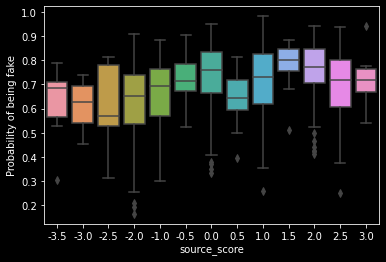

In [38]:
ax = sns.boxplot(x=visual_check.source_score, y=predicted_probas[:, 0])

ax.set_ylabel("Probability of being fake")

plt.savefig(
    BASE_DATA_DIR
    / "processed"
    / "trained_nela-gt-2018-articles-probability-of-being-fake.png"
)

Model does have potential to separate true stories from fake ones. At least it's performance on training set is not absolutely atrocious.

Now I have two ideas:
1. I'm representing whole article as 300 numbers. I could give my model more information
2. Data might not be linearly separable, I can try more complex model.

Solution 2. is simpler to code, so I'll go with it first.

#### LightGBM

In [39]:
train_dataset = lgb.Dataset(train_encodings, label=train_articles_df.is_fake)
val_dataset = lgb.Dataset(val_encodings, label=val_articles_df.is_fake)
original_dataset = lgb.Dataset(original_encodings, label=df_merged.is_fake)

In [40]:
param = {
    "num_leaves": 15,
    "max_depth": 5,
    "objective": "binary",
    "min_data_in_leaf": train_articles_df.shape[0] // 100,
    "is_unbalance": True,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.5,
    "extra_trees": True,
    "l1_regularization": 1e-5,
    "l2_regularization": 1e-3,
    "path_smooth": 1e-5,
}
param["metric"] = "auc"
num_round = 3000
bst = lgb.train(
    param,
    train_dataset,
    num_round,
    # I fail to make lgbm only consider the first metric for early stopping
    # so I'm dropping original_dataset from val sets
    # I'll calculate auc by hand
    valid_sets=[val_dataset],
    valid_names=["val"],
    early_stopping_rounds=min(num_round // 10, 1000),
)
print(f"Best val auc: {bst.best_score}")
orig_preds = bst.predict(original_encodings, num_iteration=bst.best_iteration)
orig_auc = roc_auc_score(df_merged.is_fake, orig_preds)
print(f"Original dataset auc: {orig_auc}")
train_preds = bst.predict(train_encodings, num_iteration=bst.best_iteration)
train_auc = roc_auc_score(train_articles_df.is_fake, train_preds)
print(f"Training auc: {train_auc}")

/home/julius/lp/Turing/jjuoda-DL.4/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 55210, number of negative: 119637
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.366114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153000
[LightGBM] [Info] Number of data points in the train set: 174847, number of used features: 600
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315762 -> initscore=-0.773318
[LightGBM] [Info] Start training from score -0.773318
[1]	val's auc: 0.582066
Training until validation scores don't improve for 300 rounds
[2]	val's auc: 0.619073
[3]	val's auc: 0.643068
[4]	val's auc: 0.647166
[5]	val's auc: 0.652225
[6]	val's auc: 0.658459
[7]	val's auc: 0.655961
[8]	val's auc: 0.662781
[9]	val's auc: 0.658257
[10]	val's auc: 0.655805
[11]	val's auc: 0.653757
[12]	val's auc: 0.654949
[13]	val's auc: 0.654834
[14]	val's auc: 0.651311
[15]	val's auc: 0.650788
[16]	val's auc: 0.650185
[17]	val's auc: 0.647383
[18]	val's auc: 0.64

Ok, my selected task to train models on is relevant.  
Auc on original dataset - even tho model did not see at all is higher than on nela-gt-2018, data similar to one seen in training.

I've also played a bit with parameters, best val auc I got was about .74, way better than what I had before.

In [41]:
preds = []

sample = (
    nela_gt_2018_articles_df[nela_gt_2018_articles_df.split == "pred"]
    .dropna(subset=["title"])
    .sample(n=10000)
)

for enc, labels in batched_preprocessing(sample, pretrained_fasttext, batch_size=128):
    preds.append(bst.predict(enc))
preds = np.concatenate(preds)

0it [00:00, ?it/s]

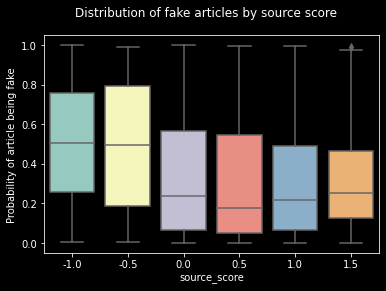

In [42]:
ax = sns.boxplot(x=sample.source_score, y=preds)
ax.set_ylabel("Probability of article being fake")

plt.suptitle("Distribution of fake articles by source score")
plt.savefig(BASE_DATA_DIR / "processed" / "fake-articles-by-source-score-lgbm.png")

Ok, the trend looks as it should - decreasing probability of news being fake with source score increasing. Auc looks promising, but not usable yet.

#### Error analysis

Let's try to improve it.

First of all - which samples model predicted well?

In [43]:
val_preds = bst.predict(val_encodings)

In [44]:
val_errors = pd.DataFrame(index=val_articles_df.index)
val_errors["is_fake"] = val_articles_df.is_fake
val_errors["predicted_score"] = val_preds
val_errors["error"] = np.abs(val_errors.is_fake - val_errors.predicted_score)

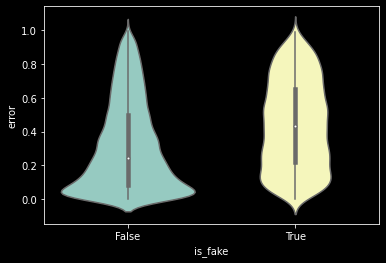

In [45]:
sns.violinplot(x=val_errors.is_fake, y=val_errors.error, bins=100)
plt.savefig(BASE_DATA_DIR / "processed" / "error-distribution-lgbm.png")

Errors for unreliable sources are close to uniformly distributed. I'd say errors for "true" news resemble F distribution, but I'm just eyeballing.

I weight title as important as whole article text and it's much quicker to check title. Let's look at titles of mistaken articles.

In [46]:
largest_errors = val_errors.sort_values("error", ascending=False)
errors_on_reliable_sources = (
    val_articles_df.loc[largest_errors.index]
    .loc[val_articles_df.source_score > 0]
    .head(10)
)
errors_on_unreliable_sources = (
    val_articles_df.loc[largest_errors.index]
    .loc[val_articles_df.source_score < 0]
    .head(10)
)
# I'm shuffling since I'll be trying to predict if news are fake or not myself, looking at title only
largest_errors = pd.concat(
    [errors_on_reliable_sources, errors_on_unreliable_sources]
).sample(frac=1, random_state=42)

In [47]:
with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
    print(val_articles_df.loc[largest_errors.index, "title"].str.lower())

35028                                                                       georgias rave revolution
12666                   1488 detained migrant children are now missing trump administration to blame
566853                        house passes bill to overhaul sexual harassment policy on capitol hill
515221                                                            south koreas spy cam porn epidemic
76001                                                      ground-breaking galaxy collision detected
60509                                                            bulgaria smashes fake passport scam
296691                  the bipartisan budget act of 2018 whats in the mcconnell-schumer budget deal
588943                                                    diver dies in thailand cave rescue attempt
360900                 breaking vietnam war hero senator john mccain has died president trump silent
319461                                            five things to know about the att-time wa

In [48]:
julius_guesses = [
    bool(i) for i in (1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0)
]

In [49]:
julius_accuracy = (
    julius_guesses == val_articles_df.loc[largest_errors.index, "is_fake"]
).mean()
julius_accuracy

0.75

In [50]:
pd.DataFrame(
    {
        "title": val_articles_df.loc[largest_errors.index, "title"],
        "julius_guess": julius_guesses,
        "is_fake": val_articles_df.loc[largest_errors.index, "is_fake"],
    }
)

,title,julius_guess,is_fake
35028,Georgias rave revolution,True,False
12666,1488 Detained Migrant Children Are Now Missing...,True,True
566853,House Passes Bill to Overhaul Sexual Harassmen...,False,True
515221,South Koreas spy cam porn epidemic,False,False
76001,Ground-breaking galaxy collision detected,False,False
60509,Bulgaria smashes fake passport scam,False,False
296691,The Bipartisan Budget Act of 2018 Whats In the...,False,True
588943,Diver dies in Thailand cave rescue attempt,False,False
360900,BREAKING Vietnam War Hero Senator John McCain ...,True,True
319461,Five Things to Know About the ATT-Time Warner ...,True,True


Ok, so I can be better than model on unseen data looking at title only.  
0.75 is even better than random chance :D (I specifically made dataset so random guessing would get around .5).  
When I myself was looking I mainly looked for emotionally charged words like "raging" and "derp". I also looked if article seems to be about US politics, since most fake news were about that. I guess my processing with fasttext does dilute contribution of individual words, since fasttext to get sentence embeddings just averages meaning of every word into a sentence. Let try using TD-IDF, to add information about individual keywords back.

In [51]:
num_keywords = 300

title_tfidf_vectorizer = TfidfVectorizer(
    max_features=num_keywords,
    stop_words="english",
).fit(train_articles_df.title)

By scanning through, very American list.

In [52]:
text_tfidf_vectorizer = TfidfVectorizer(
    max_features=num_keywords,
    stop_words="english",
).fit(train_articles_df.title)

In [53]:
def get_tfidf_vectors(articles_df):
    title_vectors = title_tfidf_vectorizer.transform(articles_df.title).todense()
    text_vectors = text_tfidf_vectorizer.transform(articles_df.text).todense()
    return np.array(np.concatenate([title_vectors, text_vectors], axis=1))

In [54]:
train_features = np.concatenate(
    [train_encodings, get_tfidf_vectors(train_articles_df)], axis=1
)
val_features = np.concatenate(
    [val_encodings, get_tfidf_vectors(val_articles_df)], axis=1
)
original_features = np.concatenate(
    [original_encodings, get_tfidf_vectors(df_merged)], axis=1
)

In [55]:
train_dataset = lgb.Dataset(train_features, label=train_articles_df.is_fake.values)
val_dataset = lgb.Dataset(val_features, label=val_articles_df.is_fake.values)
original_dataset = lgb.Dataset(original_features, label=df_merged.is_fake.values)

param = {
    "num_leaves": 15,
    "max_depth": 5,
    "objective": "binary",
    "min_data_in_leaf": train_articles_df.shape[0] // 100,
    "is_unbalance": True,
    "feature_fraction": 0.5,
    "extra_trees": True,
    "l1_regularization": 1,
    "l2_regularization": 1e-3,
    "path_smooth": 1e-5,
    "max_bins": 2 ** 6,
}
param["metric"] = "auc"
num_round = 100000
bst = lgb.train(
    param,
    train_dataset,
    num_round,
    # I fail to make lgbm only consider the first metric for early stopping
    # so I'm dropping original_dataset from val sets
    # I'll calculate auc by hand
    valid_sets=[val_dataset],
    valid_names=["val"],
    early_stopping_rounds=min(num_round // 10, 1000),
)
print(f"Best val auc: {bst.best_score}")
orig_preds = bst.predict(original_features, num_iteration=bst.best_iteration)
orig_auc = roc_auc_score(df_merged.is_fake, orig_preds)
print(f"Original dataset auc: {orig_auc}")
train_preds = bst.predict(train_features, num_iteration=bst.best_iteration)
train_auc = roc_auc_score(train_articles_df.is_fake, train_preds)
print(f"Training auc: {train_auc}")

/home/julius/lp/Turing/jjuoda-DL.4/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 55210, number of negative: 119637
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.362981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59837
[LightGBM] [Info] Number of data points in the train set: 174847, number of used features: 935
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315762 -> initscore=-0.773318
[LightGBM] [Info] Start training from score -0.773318
[1]	val's auc: 0.653945
Training until validation scores don't improve for 1000 rounds
[2]	val's auc: 0.632249
[3]	val's auc: 0.64428
[4]	val's auc: 0.635933
[5]	val's auc: 0.637603
[6]	val's auc: 0.626356
[7]	val's auc: 0.629666
[8]	val's auc: 0.624522
[9]	val's auc: 0.631023
[10]	val's auc: 0.625988
[11]	val's auc: 0.629554
[12]	val's auc: 0.633037
[13]	val's auc: 0.639461
[14]	val's auc: 0.642071
[15]	val's auc: 0.649208
[16]	va

I've tried playing around, it seems that adding more features increased overfitting without improving performance on the validation set.  
But I dislike such large gap between training performance and validation performance.

Before moving to deep learning, let's try to model what I as a human was looking for - differences in tone and topics covered between fake and real news. Maybe K neighbors could pick that up?

### K methods

#### KNN

In [56]:
def get_metrics(features, labels, cb_pred_proba):
    assert len(features) == len(labels)
    metrics = {k: {"auc": np.nan, "accuracy": np.nan} for k in features}
    for name, values in features.items():
        preds = cb_pred_proba(values)
        metrics[name]["auc"] = roc_auc_score(labels[name], preds)
        metrics[name]["accuracy"] = ((preds > 0.5) == labels[name]).mean()
    return metrics

In [57]:
def get_metrics(
    features: Dict[str, np.ndarray],
    labels: Dict[str, np.ndarray],
    cb_pred_proba: Callable[[np.ndarray], np.ndarray],
) -> Dict[str, Dict[str, float]]:
    """Calculate auc and accuracy for each feature set.

    Args:
        features (Dict[str, np.ndarray]): features in form of {"train": train_features, ...}
        labels (Dict[str, np.ndarray]): labels in form of {"train": train_labels, ...}
        cb_pred_proba (Callable[[np.ndarray], np.ndarray]): function taking features
            and returning class probabilities

    Returns:
        Dict[str, Dict[str, float]]: metrics in form
            {"train": {"auc": train_auc, "accuracy": train_accuracy}, ...}
    """
    assert len(features) == len(labels)
    metrics = {k: {"auc": np.nan, "accuracy": np.nan} for k in features}
    for name, values in features.items():
        preds = cb_pred_proba(values)
        metrics[name]["auc"] = roc_auc_score(labels[name], preds)
        metrics[name]["accuracy"] = ((preds > 0.5) == labels[name]).mean()
    return metrics


def knn_predict_proba(neighbors, labels, n_neighbors):
    """Reimplements sklearn knn, but I avoid calculating distances multiple times"""
    return labels[neighbors[:, :n_neighbors]].mean(axis=1)


def evaluate_knn(
    features: Dict[str, np.ndarray],
    labels: Dict[str, np.ndarray],
    kmin: int = 1,
    kmax: int = 64,
    step_size: int = 1,
    sampler: BaseSampler = None,
) -> Dict[str, Dict[str, float]]:
    """Evaluate KNearestNeighbors classifier across a range of k values.

    Args:
        features (Dict[str, np.ndarray]): features in form of {"train": train_features, ...}
            at least train features is required
        labels (Dict[str, np.ndarray]): labels in form of {"train": train_labels, ...}
        kmin (int, optional): minimum k value to evaluate. Defaults to 1.
        kmax (int, optional): maximum k value to evaluate. Defaults to 512.
        step_size (int, optional): step size for k values. Defaults to 1.
        sampler (BaseSampler, optional): sampler to use. Defaults to None.

    Returns:
        Dict[str, Dict[str, float]]: metrics in form
            {"train": {"auc": train_auc, "accuracy": train_accuracy}, ...}
    """
    assert len(features) == len(labels)
    for name in features:
        assert len(features[name]) == len(labels[name])
    if sampler:
        train_features_full, train_labels_full = sampler.fit_resample(
            features["train"], labels["train"]
        )
    else:
        train_features_full, train_labels_full = features["train"], labels["train"]
    knn_classifier = KNeighborsClassifier(n_neighbors=kmax)
    knn_classifier.fit(train_features_full, train_labels_full)

    # copy references so I can mess with dict in-place without modifying the original
    features = copy(features)
    # I don't need every training sample to calculate training metrics
    features["train"] = features["train"][:10000]
    labels["train"] = labels["train"][:10000]

    # most expensive part of this function is calculating distances
    # (we only care about neighbors, not distances)
    neighbors = {
        name: knn_classifier.kneighbors(features[name], return_distance=False)
        for name in features
    }

    metrics = {}
    for n_neighbors in tqdm(range(kmax, kmin, -step_size), position=1):
        metrics[n_neighbors] = get_metrics(
            neighbors, labels, lambda x: knn_predict_proba(x, train_labels_full, n_neighbors)
        )

    return metrics

We may finally be overfitting to our new dataset - performance on original dataset is worse than on nela-gt-2018 (still pretty good).

I'll make a table summarising knn results.

In [58]:
results_df = pd.read_csv(
    BASE_DATA_DIR / "processed/knn_results_fasttext.csv", index_col=0
)

# I can't figure out how to disable pandas convertion from string N/A to pd.NaN
# I'll just fill nas here
results_df.fillna(value="N/A", inplace=True)

In [59]:
melted_results_df = pd.melt(
    results_df,
    id_vars=["distance_metric", "upsampler", "n_neighbors"],
    var_name="metric",
)

(0.6, 1.0)

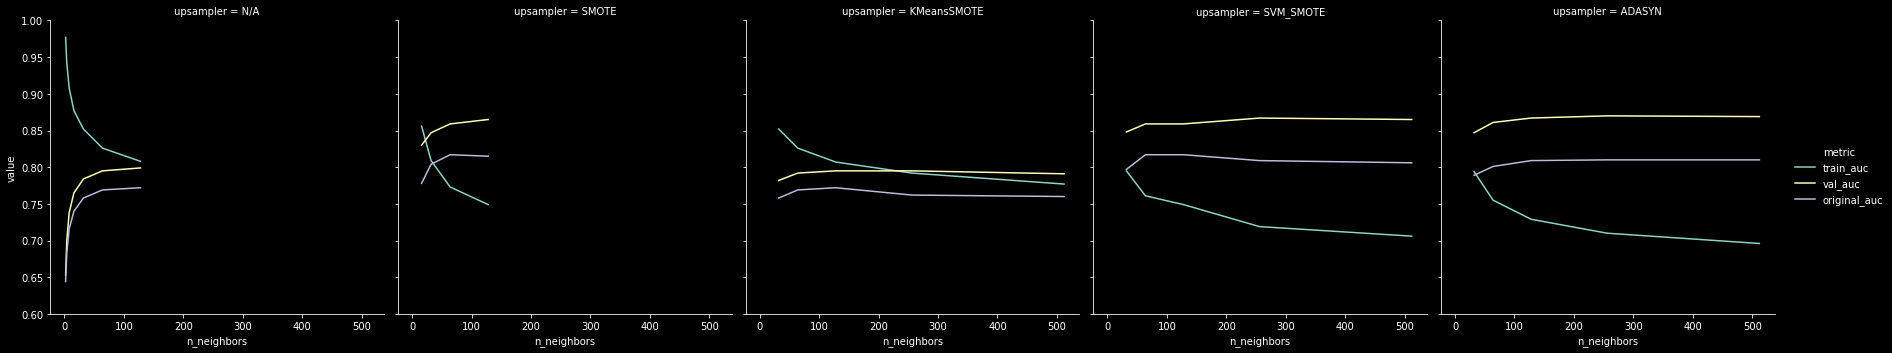

In [60]:
sampler_order = ["N/A", "SMOTE", "KMeansSMOTE", "SVM_SMOTE", "ADASYN"]

sns.relplot(
    data=melted_results_df[melted_results_df.distance_metric == "euclidean"],
    x="n_neighbors",
    y="value",
    hue="metric",
    col="upsampler",
    kind="line",
    col_order=sampler_order,
)

plt.ylim(0.6, 1)

Let's distill the view to only validation performance.

In [61]:
pivot = melted_results_df[
    (melted_results_df.metric == "val_auc")
    & (melted_results_df.distance_metric == "euclidean")
].pivot_table(index="upsampler", columns="n_neighbors", values="value", aggfunc="mean")

<AxesSubplot:xlabel='n_neighbors', ylabel='upsampler'>

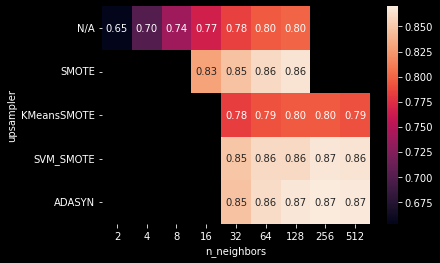

In [62]:
sns.heatmap(pivot.loc[sampler_order], annot=True, fmt=".2f")

So it's pretty clear that upsampling helps. Doesn't seem to particularly matter which upsampling method I use, as long as it's not KMeans :D
Admittedly, I didn't tune it but it needing tuning would be a reason to not use it.

I'd likely use 32 or 64 neighbours, since even though more neighbours help, runtime gets prohibitive.

Let's see if extra tf-idf features help.

In [63]:
upsamplers = {
    # "smote": over_sampling.SMOTE(random_state=42),
    # SVM_SMOTE takes too long and isn't worth it
    # "svm_smote": over_sampling.SVMSMOTE(random_state=42),
    # "adasyn": over_sampling.ADASYN(random_state=42),
    # "N/A": None,
}
metrics = {}
for sampler_name, sampler in tqdm(upsamplers.items(), position=0):
    with joblib.parallel_backend("threading", n_jobs=4):
        metrics[sampler_name] = evaluate_knn(
            {
                "train": train_features,
                "val": val_features,
                "original": original_features,
            },
            {
                "train": train_articles_df.is_fake.values,
                "val": val_articles_df.is_fake.values,
                "original": df_merged.is_fake.values,
            },
            sampler=sampler,
            kmax=256,
        )

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

In [80]:
# metrics_records = []
# for sampler in metrics:
#     for k in metrics[sampler]:
#         for split in metrics[sampler][k]:
#             for metric in metrics[sampler][k][split]:
#                 metrics_records.append(
#                     {
#                         "distance_metric": "euclidean",
#                         "upsampler": sampler,
#                         "n_neighbors": k,
#                         "metric": metric,
#                         "split": split,
#                         "value": metrics[sampler][k][split][metric],
#                     }
#                 )
# metrics_df = pd.DataFrame(metrics_records)
# del metrics_records
metrics_df = pd.read_csv(BASE_DATA_DIR / "processed/knn_results_fasttext_tfidf.csv")
metrics_df

,Unnamed: 0,distance_metric,upsampler,n_neighbors,metric,split,value
0,0,euclidean,smote,256,auc,train,0.696535
1,1,euclidean,smote,256,accuracy,train,0.401700
2,2,euclidean,smote,256,auc,val,0.644425
3,3,euclidean,smote,256,accuracy,val,0.328478
4,4,euclidean,smote,256,auc,original,0.663048
...,...,...,...,...,...,...,...
4585,4585,euclidean,NaN,2,accuracy,train,0.886000
4586,4586,euclidean,NaN,2,auc,val,0.593146
4587,4587,euclidean,NaN,2,accuracy,val,0.736624
4588,4588,euclidean,NaN,2,auc,original,0.588989


Text(24.050066550925926, 0.5, 'AUC')

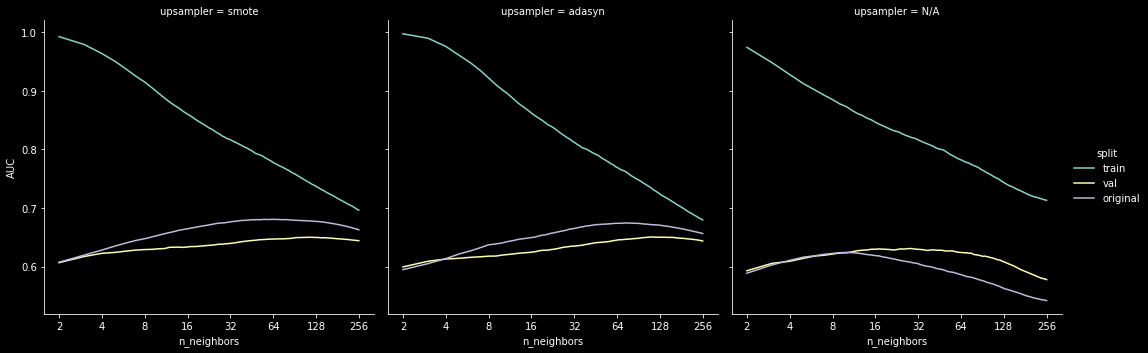

In [ ]:
grid = sns.relplot(
    data=metrics_df[metrics_df.metric == "auc"],
    x="n_neighbors",
    y="value",
    hue="split",
    col="upsampler",
    kind="line",
)

max_power = 8
for rows in grid.axes:
    for ax in rows:
        ax.set_xscale("log", base=2)
        ticks = plt.xticks()
        plt.xticks([2 ** i for i in range(1, max_power + 1)], [str(2 ** i) for i in range(1, max_power + 1)])

grid.axes[0, 0].set_ylabel("AUC")

Again those extra tf-idf features didn't add anything and only hurt performance. Let's go do deep learning.